In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Importing Packages**




In [5]:
import pandas as pd
import numpy as np

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GRU, Bidirectional, Dropout
from keras.utils import plot_model

import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import math
import warnings
warnings.filterwarnings("ignore")
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error

### *Initializing Window size*

In [6]:
window_size = 50

# **Functions**

In [7]:
def read_label():
    label = {}
    for i in range(1,5):
        label_path = '/content/gdrive/MyDrive/energy_disaggregation/windowGRU/data/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(label_path) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label


#-------------------------------------------------------------------------------------------------------------------

def read_merge_data(house):
    path = '/content/gdrive/MyDrive/energy_disaggregation/windowGRU/data/house_{}/'.format(house)
    
    
    file = path + 'channel_1.dat'

    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 

    num_apps = len(glob.glob(path + 'channel*'))

    
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df

#-------------------------------------------------------------------------------------------------------------------

def uniform_label(df):
  if 'dishwaser_6' in df.columns:   
    df = df.rename(columns={'dishwaser_6': 'dishwasher'})

  if 'dishwaser_10' in df.columns:
    df = df.rename(columns={'dishwaser_10': 'dishwasher'})

  if 'dishwaser_9' in df.columns:
    df = df.rename(columns={'dishwaser_9': 'dishwasher'})

  if 'dishwaser_15' in df.columns:
    df = df.rename(columns={'dishwaser_15': 'dishwasher'})

  return df

#----------------------------------------------------------------------------------------------------------------------

def add_houses(df_list, appliance):
  merged_df = pd.DataFrame()
  for df in df_list:
    df = uniform_label(df)

    df["aggregate_mains"] = df['mains_1'] + df['mains_2']
    df = df[['aggregate_mains',appliance]]
    
    merged_df = pd.concat([merged_df,df])
  return merged_df

#-----------------------------------------------------------------------------------------------------------------------

def max_value(df):
  return max(df['aggregate_mains'])

#-----------------------------------------------------------------------------------------------------------------------

def preprocess_data(df, appliance, nmax):

  df['aggregate_mains'] = df['aggregate_mains']/ nmax

  df[appliance] = df[appliance]/ nmax
  
  return df 

#----------------------------------------------------------------------------------------------------------------------
def create_window_chunk(df, sequence_length):
  result = []
  for index in range(len(df) - sequence_length):
      result.append(df[index: index + sequence_length])

  return result

#----------------------------------------------------------------------------------------------------------------------

def _create_model(window_size):
    '''Creates the GRU architecture described in the paper
    '''
    model = Sequential()

    # 1D Conv
    model.add(Conv1D(16, 4, activation='relu', input_shape=(window_size,1), padding="same", strides=1))
    #Bi-directional GRUs
    model.add(Bidirectional(GRU(64, activation='relu', return_sequences=True), merge_mode='concat'))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(128, activation='relu', return_sequences=False), merge_mode='concat'))
    model.add(Dropout(0.2))


    # Fully Connected Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')
    print(model.summary())

    return model

#---------------------------------------------------------------------------------------------------------------------







# **Data Preprocessing**

In [8]:
df_dic = {}
dates = {}

### *Reading and storing labels of all the houses in a dictionary*

In [9]:
labels = read_label()
labels

{1: {1: 'mains_1',
  2: 'mains_2',
  3: 'oven_3',
  4: 'oven_4',
  5: 'refrigerator_5',
  6: 'dishwaser_6',
  7: 'kitchen_outlets_7',
  8: 'kitchen_outlets_8',
  9: 'lighting_9',
  10: 'washer_dryer_10',
  11: 'microwave_11',
  12: 'bathroom_gfi_12',
  13: 'electric_heat_13',
  14: 'stove_14',
  15: 'kitchen_outlets_15',
  16: 'kitchen_outlets_16',
  17: 'lighting_17',
  18: 'lighting_18',
  19: 'washer_dryer_19',
  20: 'washer_dryer_20'},
 2: {1: 'mains_1',
  2: 'mains_2',
  3: 'kitchen_outlets_3',
  4: 'lighting_4',
  5: 'stove_5',
  6: 'microwave_6',
  7: 'washer_dryer_7',
  8: 'kitchen_outlets_8',
  9: 'refrigerator_9',
  10: 'dishwaser_10',
  11: 'disposal_11'},
 3: {1: 'mains_1',
  2: 'mains_2',
  3: 'outlets_unknown_3',
  4: 'outlets_unknown_4',
  5: 'lighting_5',
  6: 'electronics_6',
  7: 'refrigerator_7',
  8: 'disposal_8',
  9: 'dishwaser_9',
  10: 'furance_10',
  11: 'lighting_11',
  12: 'outlets_unknown_12',
  13: 'washer_dryer_13',
  14: 'washer_dryer_14',
  15: 'lighting

### *Converting raw dataset of a house into Pandas Dataframe and storing all the dataframes in a dictionary*

In [10]:
for i in range(1,5):
    df_dic[i] = read_merge_data(i)
    
print(df_dic)

{1:                      mains_1  mains_2  ...  washer_dryer_19  washer_dryer_20
2011-04-18 13:22:13   222.20   118.83  ...              0.0              0.0
2011-04-18 13:22:16   223.17   119.19  ...              0.0              0.0
2011-04-18 13:22:20   223.60   118.92  ...              0.0              0.0
2011-04-18 13:22:23   222.91   119.16  ...              0.0              0.0
2011-04-18 13:22:26   222.94   118.83  ...              0.0              0.0
...                      ...      ...  ...              ...              ...
2011-05-24 19:56:20   235.73    38.65  ...              0.0              0.0
2011-05-24 19:56:23   235.03    38.66  ...              0.0              0.0
2011-05-24 19:56:27   235.46    38.61  ...              0.0              0.0
2011-05-24 19:56:30   235.98    38.77  ...              0.0              0.0
2011-05-24 19:56:34   235.29    38.83  ...              0.0              0.0

[406748 rows x 20 columns], 2:                      mains_1  mains_2  .

### *Checking the Number of days of available data of different houses*

In [11]:
for i in range(1,5):
    dates[i] = [str(time)[:10] for time in df_dic[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

House 3 data contain 26 days from 2011-04-16 to 2011-05-31.
['2011-04-16', '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-21', '2011-05-22', '2011-05-23', '

In [12]:
for i in range(1,5):
    print('House {} data has shape: '.format(i), df_dic[i].shape)
    display(df_dic[i].tail(3))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:34,235.29,38.83,0.0,0.0,186.0,0.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-05-22 23:59:01,10.84,252.61,0.0,9.0,0.0,5.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:04,10.88,253.02,0.0,9.0,0.0,4.0,0.0,2.0,160.0,0.0,0.0
2011-05-22 23:59:08,10.84,252.77,0.0,9.0,0.0,4.0,0.0,2.0,157.0,0.0,0.0


House 3 data has shape:  (376150, 22)


,mains_1,mains_2,outlets_unknown_3,outlets_unknown_4,lighting_5,electronics_6,refrigerator_7,disposal_8,dishwaser_9,furance_10,lighting_11,outlets_unknown_12,washer_dryer_13,washer_dryer_14,lighting_15,microwave_16,lighting_17,smoke_alarms_18,lighting_19,bathroom_gfi_20,kitchen_outlets_21,kitchen_outlets_22
2011-05-31 00:19:30,15.45,2.23,0.0,1.0,1.0,1139.0,8.0,6.0,3.0,7.0,147.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:33,15.42,2.23,0.0,1.0,1.0,1138.0,8.0,6.0,3.0,7.0,147.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5
2011-05-31 00:19:36,15.44,2.23,0.0,1.0,1.0,1134.0,7.0,6.0,3.0,7.0,147.0,0.0,0.0,0.0,1.0,2.0,10.0,0.0,0.0,0.0,0.0,2.5


House 4 data has shape:  (428076, 20)


,mains_1,mains_2,lighting_3,furance_4,kitchen_outlets_5,outlets_unknown_6,washer_dryer_7,stove_8,air_conditioning_9,air_conditioning_10,miscellaeneous_11,smoke_alarms_12,lighting_13,kitchen_outlets_14,dishwaser_15,bathroom_gfi_16,bathroom_gfi_17,lighting_18,lighting_19,air_conditioning_20
2011-06-04 00:45:31,403.36,94.65,173.0,27.0,38.0,3.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:35,401.11,94.63,174.0,27.0,34.0,4.0,1.0,5.0,0.0,0.0,1.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0
2011-06-04 00:45:38,400.24,94.43,175.0,27.0,38.0,4.0,1.0,5.0,0.0,0.0,2.0,0.0,25.0,135.0,0.0,0.0,1.0,0.0,0.0,0.0


### *Preparing training data - house 2 & 3, Appliance Dishwasher*

In [13]:
df_list = [df_dic[2], df_dic[3]]
dfs = add_houses(df_list, 'dishwasher')

In [14]:
dfs

,aggregate_mains,dishwasher
2011-04-18 05:31:40,38.32,1.0
2011-04-18 05:31:44,38.32,0.0
2011-04-18 05:31:47,38.33,1.0
2011-04-18 05:31:50,38.27,0.0
2011-04-18 05:32:05,38.25,1.0
...,...,...
2011-05-31 00:19:23,17.70,3.0
2011-05-31 00:19:26,17.71,3.0
2011-05-31 00:19:30,17.68,3.0
2011-05-31 00:19:33,17.65,3.0


### *Creating window chunk and normalizing dataframe*

In [15]:
nmax= max_value(dfs)

In [16]:
df = preprocess_data(dfs, 'dishwasher', nmax)
print(df.head())


                     aggregate_mains  dishwasher
2011-04-18 05:31:40         0.004754    0.000124
2011-04-18 05:31:44         0.004754    0.000000
2011-04-18 05:31:47         0.004756    0.000124
2011-04-18 05:31:50         0.004748    0.000000
2011-04-18 05:32:05         0.004746    0.000124


In [17]:
sequence_length = window_size

x = create_window_chunk(df['aggregate_mains'], sequence_length)

y = df['dishwasher'][sequence_length:]

In [18]:
x = np.array(x)
y = np.array(y)

### *reshaping the data*

In [21]:
x_train = np.reshape(x, (x.shape[0], x.shape[1], 1))

# **Creating Model**

In [23]:
model = _create_model(window_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 16)            80        
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 128)           31488     
_________________________________________________________________
dropout (Dropout)            (None, 50, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               198144    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

###*training model*

In [24]:
start = time.time()
model.fit(x_train, y, epochs=15, batch_size=512, shuffle=True, validation_split=0.33)
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/15
907/907 [==============================] - 1206s 1s/step - loss: 1.0218e-04 - val_loss: 5.9859e-05
Epoch 2/15
907/907 [==============================] - 1199s 1s/step - loss: 7.4886e-05 - val_loss: 5.5235e-05
Epoch 3/15
907/907 [==============================] - 1204s 1s/step - loss: 7.1918e-05 - val_loss: 5.3474e-05
Epoch 4/15
907/907 [==============================] - 1202s 1s/step - loss: 6.8322e-05 - val_loss: 5.3002e-05
Epoch 5/15
907/907 [==============================] - 1208s 1s/step - loss: 6.7856e-05 - val_loss: 6.3670e-05
Epoch 6/15
907/907 [==============================] - 1212s 1s/step - loss: 6.4337e-05 - val_loss: 6.0940e-05
Epoch 7/15
907/907 [==============================] - 1214s 1s/step - loss: 6.2612e-05 - val_loss: 5.2509e-05
Epoch 8/15
907/907 [==============================] - 1243s 1s/step - loss: 6.1049e-05 - val_loss: 5.2584e-05
Epoch 9/15
907/907 [==============================] - 1253s 1s/step - loss: 5.8522e-05 - val_loss: 5.5592e-05
Epoch 10/1

###*Saving the trained model*

In [25]:
model.save("gdrive/MyDrive/saved_model/new_dishwasher_tr_2_3_t_1_e_15_b_512_w_50_d_0.2_v_0.33_s_t.h5")

### *Preparing and preprocessing test data - house 1*

In [27]:
df_list = [df_dic[1]]
dfs_test = add_houses(df_list, 'dishwasher')

In [28]:
df_test = preprocess_data(dfs_test, "dishwasher", nmax)

print(df_test.head())

                     aggregate_mains  dishwasher
2011-04-18 13:22:13         0.042312    0.000000
2011-04-18 13:22:16         0.042477    0.000000
2011-04-18 13:22:20         0.042497    0.000000
2011-04-18 13:22:23         0.042441    0.000124
2011-04-18 13:22:26         0.042404    0.000000


In [29]:
sequence_length = window_size

x_test = create_window_chunk(df_test['aggregate_mains'], sequence_length)

y_test = df_test['dishwasher'][sequence_length:]


In [30]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [31]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

###*Predicting on the test*

In [46]:
pred_test = model.predict(x_test, batch_size=512)

In [48]:
pred_test = np.reshape(pred_test, (len(pred_test)))

### *Denormalized the test and predicted data*

In [52]:
y_test_d = y_test * nmax

In [65]:
y_pred_d = pred_test* nmax

In [ ]:
list(y_pred_d)

###*Removing the predicted readings which are below average dishwasher reading , observed dishwasher reading as 800*

In [74]:
y_pred_d = [0 if y<800 else y for y in list(y_pred_d)]

#**Data Visualization**

<function matplotlib.pyplot.show>

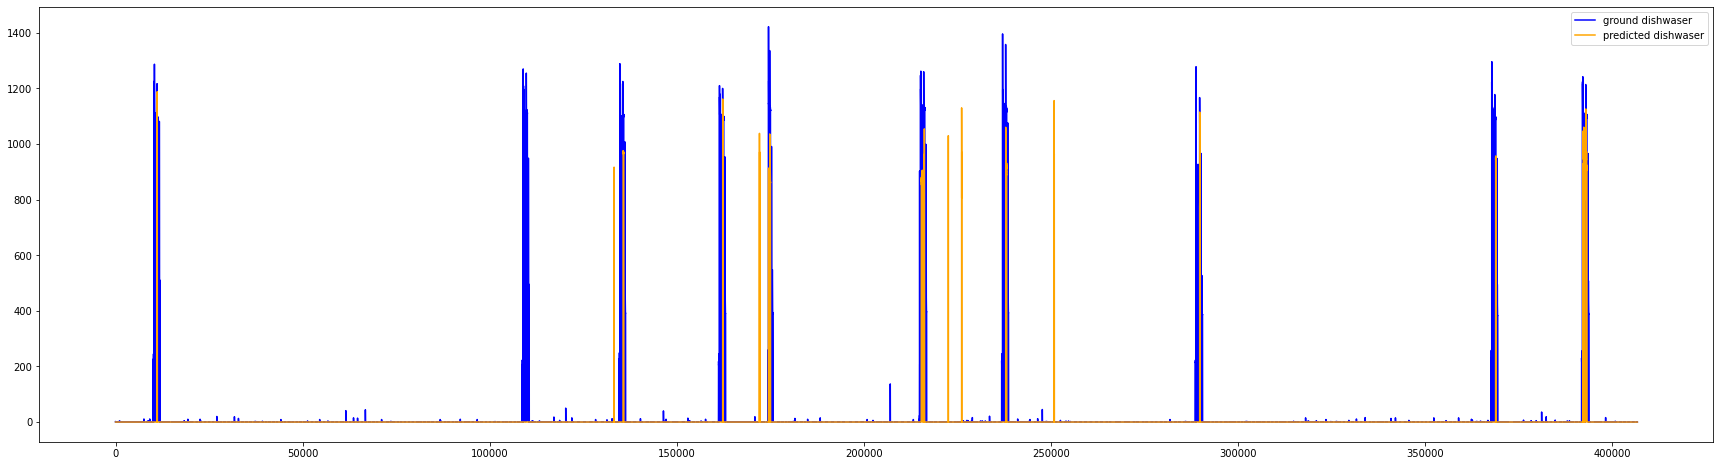

In [75]:
plt.figure(figsize = (30, 8))

plt.plot(y_test_d, color='blue', label="ground dishwaser")
plt.plot(y_pred_d, color='orange', label="predicted dishwaser")

plt.legend()
plt.show

###*Zooming into the graph*

<function matplotlib.pyplot.show>

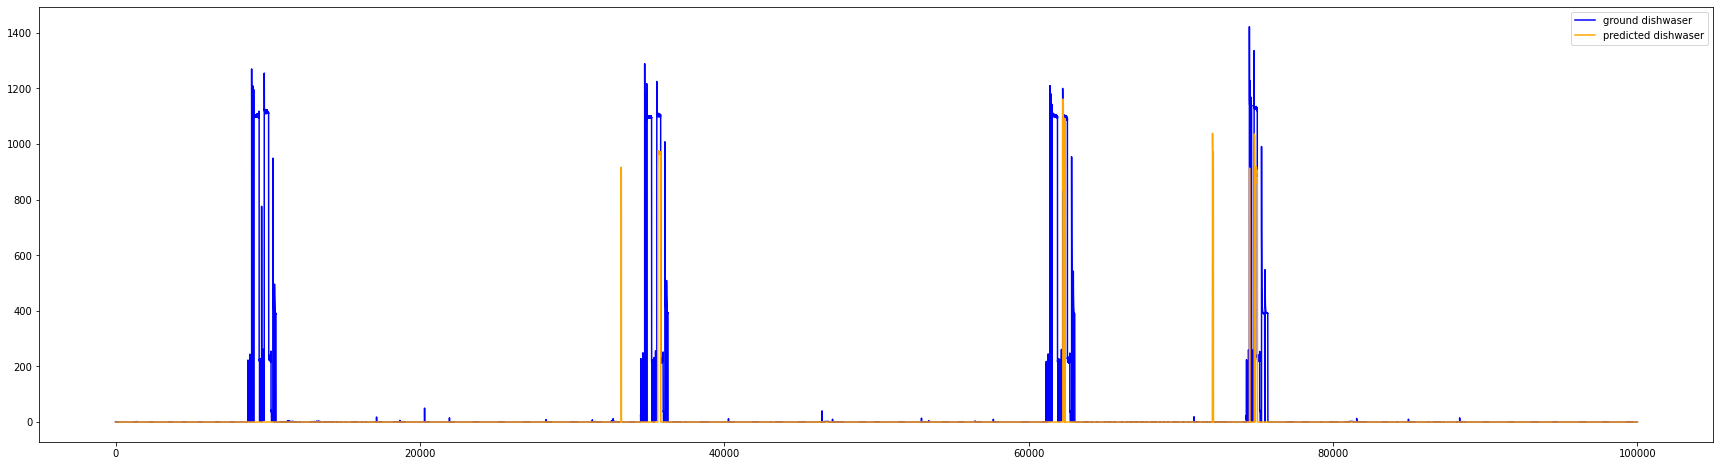

In [76]:
plt.figure(figsize = (30, 8))
plt.plot(y_test_d[100000:200000], color='blue', label="ground dishwaser")
plt.plot(y_pred_d[100000:200000], color='orange', label="predicted dishwaser")
plt.legend()
plt.show

###*More Zooming into the graph*


<function matplotlib.pyplot.show>

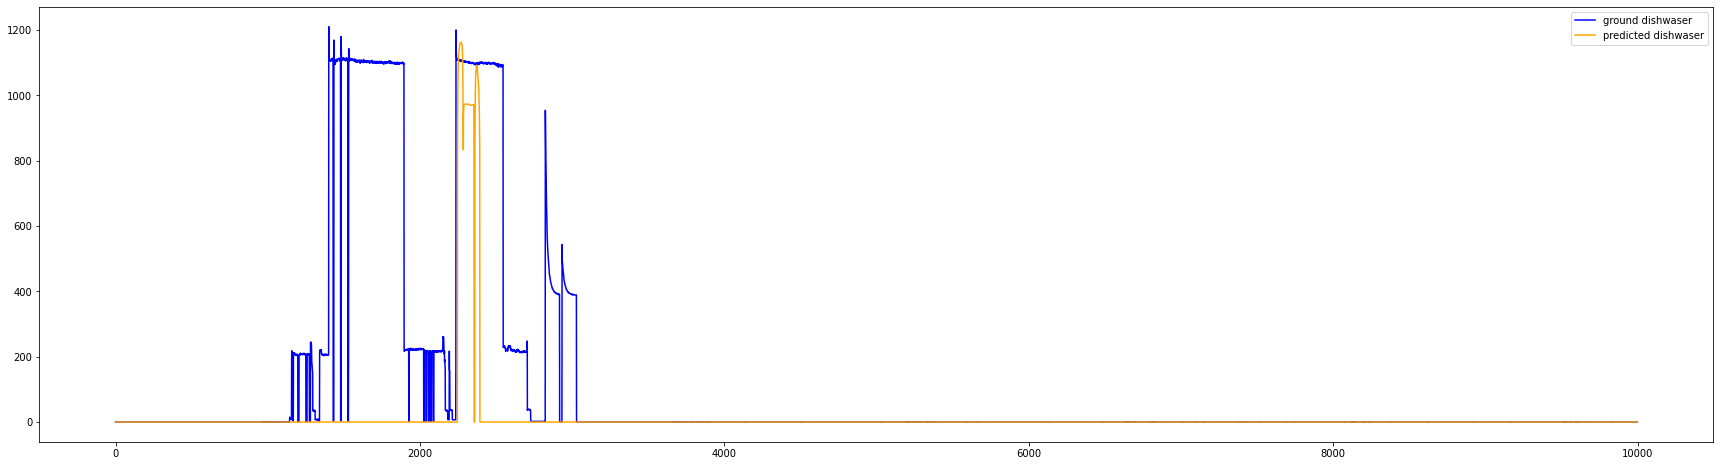

In [77]:
plt.figure(figsize = (30, 8))
plt.plot(y_test_d[160000:170000], color='blue', label="ground dishwaser")
plt.plot(y_pred_d[160000:170000], color='orange', label="predicted dishwaser")
plt.legend()
plt.show

#**Evaluation Metrics**

In [58]:
# Calculating MAE on test data

mean_absolute_error(y_test_d, y_pred_d)

21.310554751077177

In [59]:
# Calculating RMSE on test data
math.sqrt(mean_squared_error(y_test_d, y_pred_d))

114.00366441050035